In [44]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
import seaborn as sns
import pandas as pd
from sklearn import neighbors, datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn import neighbors, datasets

In [45]:
from helpers import plotPairwiseDecisionTrees

# Lecture 10: Decision Trees, Random Forest, K nearest neighbors
## 11/29/22



## Classification

Decision trees rely a series of yes or no questions to make a decision on which class an input point falls under. You've seen decision trees your entire life. Here's one made by Rosa Choe, a beloved member of the club that graduated last semester.

<img src='meme.png' width=40%>

Meme credit to $\text{Rosa Choe}^{\text{TM}}$.

As we can see from the tree above, we are able to answer a yes or no question at every step, and depending on our answer, we either went one way or another through the tree. They are very synonymous to flowcharts, but we'll go into more intricacies with decision trees later on.

Now let's apply this to the data science setting for a classification task. In particular, you're given a data point $X = \begin{bmatrix} X_1 & X_2 & ... & X_k \end{bmatrix}$, and you want to assign it a class $c$. We've seen examples of this before: logistic regression from last week tries to assign a class $c \in \{0, 1\}$ for each data point by predicting $\mathbb{P}(X = 1)$.

For a decision tree to work for this, we want to look at $X$, ask yes-no questions about its features, and assign it to a class.

<a id='dataset'></a>
### The Dataset

<img src='iris.jpg' width="250" height="250">
<center> Image from: A Complete Guide to K-Nearest-Neighbors by Zakka </center>

The dataset we'll be using is the [Iris Flower Dataset](https://archive.ics.uci.edu/ml/datasets/Iris). It contains a series of observations on three species of Iris (Iris setosa, Iris versicolor, and Iris virginica). Each observation contains four features: the *petal length, petal width, sepal length, and sepal width*. The **question** we're asking today is: can we predict the species of Iris from its *petal length, petal width, sepal length, and sepal width*.

In [46]:
#importing the data
iris = datasets.load_iris()
iris = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= ['Sepal Length', 'Sepal Width','Petal Length','Petal Width'] + ['species'])

#y contains the correct classifications (0, 1, 2 for each type of Iris)
#0 = Iris Setosa,1 = Iris Versicolour,2 = Iris Virginica
Y = iris["species"]
Y[50]

1.0

#### Summarize the dataset

In [47]:
iris.describe()

,Sepal Length,Sepal Width,Petal Length,Petal Width,species
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


In [48]:
# Let’s now take a look at the number of instances (rows) that 
# belong to each class. We can view this as an absolute count.
iris.groupby('species').size()

species
0.0    50
1.0    50
2.0    50
dtype: int64

#### Dividing the Dataframe into Feature and Labels

In [49]:
feature_columns = ['Sepal Length', 'Sepal Width','Petal Length','Petal Width']
X = iris[feature_columns].values
Y = iris['species'].values

# Alternative way of selecting features and labels arrays:
# X = dataset.iloc[:, 1:5].values
# y = dataset.iloc[:, 5].values

#### Splitting the Data into Train and Test Sets

In [50]:
#Splitting dataset into training and test
from sklearn.model_selection import train_test_split
X_train_iris, X_test_iris, Y_train_iris, Y_test_iris = train_test_split(X, Y, test_size = 0.2, random_state = 0)

An example decision tree to solve this **classification** task could look as follows:

<img src='Example Decision Tree.png'>

Let's see how this decision tree fares on our training data.

In [51]:
class TreeNode:
    #What could be an example of a split function?
    def __init__(self, left=None, right=None, split_fn=None, leaf_evaluate=None):
        self.left = left
        self.right = right
        self.split_fn = split_fn
        self.leaf_evaluate = leaf_evaluate
    
    def is_leaf(self):
        return self.left == None and self.right == None
    
    def evaluate(self, X_i):
        if self.is_leaf():
            return self.leaf_evaluate()
        if self.split_fn(X_i):
            return self.left.evaluate(X_i)
        else:
            return self.right.evaluate(X_i)

#Can you trace what the evaluate function does for a tree of depth 3?

class Leaf(TreeNode):
    
    def __init__(self, label):
        TreeNode.__init__(self, leaf_evaluate=lambda: label)
        


In [52]:
def accuracy(y_pred, y_true):
    return (y_pred == y_true).sum() / y_true.shape[0]

In [53]:
def predict(X, tree):
    if len(X.shape) == 1:
        X = X.reshape(1, -1)
    preds = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        preds[i] = tree.evaluate(X[i])
    return preds

In [54]:
root = TreeNode(
    split_fn=lambda X_i: X_i[0] > 5,
    left=TreeNode(
        split_fn=lambda X_i: X_i[2] > 3,
        left=Leaf(0),
        right=Leaf(2)
    ),
    right=TreeNode(
        split_fn=lambda X_i: X_i[3] > 3,
        left=Leaf(0),
        right=Leaf(2)
    )
)

In [55]:
preds = predict(X_train_iris, root)
preds[:5]

array([0., 0., 2., 0., 0.])

In [56]:
accuracy(preds, Y_train_iris)

0.008333333333333333

This decision tree is horrible! Maybe it's because we didn't try to train it on our data.

### Training a Decision Tree

The question is now: how do we choose how to make the splits? The answer, of course, comes from our training data.

To make things a little simpler, let's just examine the first ten data points.

In [57]:
X_train_small = X_train_iris[:10]
Y_train_small = Y_train_iris[:10]
X_train_small

array([[6.4, 3.1, 5.5, 1.8],
       [5.4, 3. , 4.5, 1.5],
       [5.2, 3.5, 1.5, 0.2],
       [6.1, 3. , 4.9, 1.8],
       [6.4, 2.8, 5.6, 2.2],
       [5.2, 2.7, 3.9, 1.4],
       [5.7, 3.8, 1.7, 0.3],
       [6. , 2.7, 5.1, 1.6],
       [5.9, 3. , 4.2, 1.5],
       [5.8, 2.6, 4. , 1.2]])

In [58]:
Y_train_small

array([2., 1., 0., 2., 2., 1., 0., 1., 1., 1.])

Say that our first split is based on sepal length (the first feature).

In [59]:
sl_0 = X_train_small[Y_train_small == 0][:, 0]
sl_1 = X_train_small[Y_train_small == 1][:, 0]
sl_2 = X_train_small[Y_train_small == 2][:, 0]

In [60]:
sl_0

array([5.2, 5.7])

In [61]:
sl_1

array([5.4, 5.2, 6. , 5.9, 5.8])

In [62]:
sl_2

array([6.4, 6.1, 6.4])

For our decision tree, how should we split on sepal length?

Just based on our training data, if we split on (Sepal Length > 6), we've isolated all irises that are class 2 (iris viginica).

<img src='Simple Decision Tree.png'/>

I decided make the "No" choice "Iris virginica". Why do you think that is the case?

In [63]:
simple = TreeNode(
    split_fn=lambda X_i: X_i[0] > 6,
    left=Leaf(2),
    right=Leaf(1)
)

In [64]:
preds = predict(X_train_small, simple)
preds

array([2., 1., 1., 2., 2., 1., 1., 1., 1., 1.])

In [65]:
accuracy(preds, Y_train_small)

0.8

Pretty good! Now let's try to come up with a programmatic way of doing this.

The intuition behind making a good decision tree is optimizing our questions (or different steps in the decision tree) to be able *to split up the data into as different categories as possible*. For example in the iris case, we would like to find a split where we may separate the various irises as much as possible. 

This idea of "splitting" to separate our irises the most introduces the idea of **entropy**. We minimize the entropy, or randomness in each split section of the data.

<a id='entropy'></a>
### Entropy

To begin, let's first define what entropy is. In the context of machine learning, entropy is **the measure of disorder  within a set** or the **amount of surprise**.

Let's take a look at our training data, and the feature we chose to split on, **sepal length**.

In [66]:
sepal_length = X_train_small[:, 0]
sepal_length

array([6.4, 5.4, 5.2, 6.1, 6.4, 5.2, 5.7, 6. , 5.9, 5.8])

In [67]:
Y_train_small

array([2., 1., 0., 2., 2., 1., 0., 1., 1., 1.])

After we split on (Sepal Length > 6), we divided our data into two halves.

In [68]:
yes = Y_train_small[sepal_length > 6]
no = Y_train_small[sepal_length <= 6]

In [69]:
yes

array([2., 2., 2.])

In [70]:
no

array([1., 0., 1., 0., 1., 1., 1.])

Let's consider a different split: (Sepal Length > 5.5).

In [71]:
yes_bad = Y_train_small[sepal_length > 5.5]
no_bad = Y_train_small[sepal_length <= 5.5]

In [72]:
yes_bad

array([2., 2., 2., 0., 1., 1., 1.])

In [73]:
no_bad

array([1., 0., 1.])

Which split was better? The first, because once we made the split, *we were more sure of what class we should predict*. How can we quantify this?

The mathematical definition of entropy is:

$$H(\textbf{p}) = -\sum_i p_i \cdot \log(p_i)$$

where $H(\textbf{p})$ is equal to the total entropy of the data set, and $p_i$ is equal to the probability of something occurring.

**Something to note:** When you calculate the entropy on a subset with data points that are all the same class, you run into a mathematical error, which is because $\log_{2}(0)$ cannot be calculated. So, as an alternative to calculating $\log_{2}(0)$, we can bring in the following limit instead (meaning our terms with $p_i = 0$ become 0:

$$\lim _{p\to 0+}p\log(p)=0$$

A great visualization for different entropies is as follows:
<img src='pictures/Entropy.png' width='50%'>

Let's say $Pr(X = 1)$ is the probability that you flips a heads, where heads is represented by $1$ and tails is represented by $0$. From this, we can see that the y-value, $H(X)$ (or calculated entropy), is at a minimum when the chance of flipping a heads is $0$ or $1$, but is at a maximum when the chance of flipping a heads is $0.5$. In other words, the data subset is the most random when there is an equal probability of all classes, and minimized when there are probabilites of classes that are equal to $0$.

When we look at a set of y-values, the entropy is:

$$\sum_{\text{class $c_i$}} -\left(\text{proportion of $c_i$'s}\right) \cdot \log \left(\text{proportion of $c_i$'s}\right)$$

In [74]:
def H(y):
    def proportion(val, y):
        return (y == val).sum() / len(y)
    unique = set(y)
    return sum(-1 * proportion(val, y) * np.log2(proportion(val, y)) for val in unique)
        

Let's see how this comes into play in our splits.

In [75]:
original_entropy = H(Y_train_small)
original_entropy

1.4854752972273344

In our good split, our entropies were:

In [76]:
H(yes), H(no)

(0.0, 0.863120568566631)

In our bad split, our entropies were:

In [77]:
H(yes_bad), H(no_bad)

(1.4488156357251847, 0.9182958340544896)

Clearly, the first split was better, because we reduced entropy the most.

To combine these statistics together for one measure, we'll take the **weighted average**, weighting by the sizes of the two sets.

In [78]:
def weighted_entropy(yes, no):
    total_size = len(yes) + len(no)
    return (len(yes) / total_size) * H(yes) + (len(no) / total_size) * H(no)

In [79]:
H(Y_train_small)

1.4854752972273344

In [80]:
weighted_entropy(yes, no)

0.6041843979966417

In [81]:
weighted_entropy(yes_bad, no_bad)

1.289659695223976

This is huge! We now have a way to choose our splits for our decision tree: 

**Find the best split value (of each feature) that reduces our entropy from the original set the most!**

### Training

In [82]:
from scipy.stats import mode

def train(X_train, Y_train, max_depth=None):
    if len(Y_train) == 0:
        return Leaf(0)
    
    if len(set(Y_train)) == 1 or max_depth == 1:
        return Leaf(mode(Y_train).mode)
    
    def split_weighted_entropy(feature_idx, feature_value):
        feature = X_train[:, feature_idx]
        yes = Y_train[feature > feature_value]
        no = Y_train[feature <= feature_value]
        return weighted_entropy(yes, no)
    
    splits = np.zeros(X_train.shape)
    for feature_idx in range(X_train.shape[1]):
        for i, feature_value in enumerate(X_train[:, feature_idx]): # try to split on each X-value
            splits[i, feature_idx] = split_weighted_entropy(feature_idx, feature_value)
    
    max_idxs = X_train.argmax(axis=0)
    for col, max_idx in enumerate(max_idxs):
        splits[max_idx, col] = float('inf')
    
    i = np.argmin(splits)
    best_feature_idx = i % splits.shape[1]
    best_feature_value = X_train[i // splits.shape[1], best_feature_idx]
    
    yes = X_train[:, best_feature_idx] > best_feature_value
    no = X_train[:, best_feature_idx] <= best_feature_value
    
    tree = TreeNode(
        split_fn=lambda X_i: X_i[best_feature_idx] > best_feature_value,
        left=train(X_train[yes], Y_train[yes], max_depth=max_depth - 1 if max_depth is not None else None),
        right=train(X_train[no], Y_train[no], max_depth=max_depth - 1 if max_depth is not None else None)
    )
    
    return tree

In [83]:
tree = train(X_train_iris, Y_train_iris)

In [84]:
preds = predict(X_train_iris, tree)
accuracy(preds, Y_train_iris)

1.0

Whoa! We have a model that performs at 100% training accuracy! Let's see what happens when we try the model on the validation set.

In [85]:
preds = predict(X_test_iris, tree)
accuracy(preds, Y_test_iris)

0.9333333333333333

We're doing significantly worse, so we're probably overfitting. What could be changed to avoid overfitting? (Hint: Look at parameters of our train function)

### Regression

How can we use decision trees to perform regression?

When we decide to make a leaf, take the mean/median of the points that are left, instead of the mode.

### Titanic

In [86]:
titanic_train = pd.read_csv('titanic/train.csv')
titanic_test = pd.read_csv('titanic/test.csv')
titanic_survived = titanic_train['Survived']
titanic_train = titanic_train.drop('Survived', axis=1)

In [87]:
full_data = pd.concat((titanic_train, titanic_test), sort=False)

In [88]:
def feature_engineering(df):
    df = df.drop(['Name', 'PassengerId', 'Age', 'Ticket'], axis=1)
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].value_counts().idxmax()) # fill with Southampton
    df['Deck'] = df['Cabin'].apply(lambda s: s[0] if s is not np.nan else 'U') # U for unassigned
    df['Fare'] = np.log(df['Fare'] + 1)
    df = df.drop('Cabin', axis=1)
    df = pd.get_dummies(df, columns=['Pclass', 'Embarked', 'Sex', 'Deck'])
    
    df = df.drop('Deck_T', axis=1)
    
    return df
    

In [89]:
full_data_cleaned = feature_engineering(full_data)

/Users/sarangmdeshpande/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [90]:
full_data_cleaned.head()

,SibSp,Parch,Fare,Pclass_First,Pclass_Second,Pclass_Third,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_U
0,1,0,2.110213,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1
1,1,0,4.280593,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0
2,0,0,2.188856,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1
3,1,0,3.990834,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0
4,0,0,2.202765,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1


In [91]:
titanic_train_cleaned = full_data_cleaned.iloc[:titanic_train.shape[0]]
titanic_test_cleaned = full_data_cleaned.iloc[titanic_train.shape[0]:]

In [92]:
X = titanic_train_cleaned.values
y = titanic_survived.values

In [93]:
X_train_titanic, X_valid_titanic, y_train_titanic, y_valid_titanic = train_test_split(X, y, test_size=0.2, random_state=42)

In [94]:
tree = train(X_train_titanic, y_train_titanic.astype(int), max_depth=10) # for computation sake

In [95]:
preds = predict(X_train_titanic, tree)
accuracy(preds, y_train_titanic)

0.9002808988764045

In [96]:
preds = predict(X_valid_titanic, tree)
accuracy(preds, y_valid_titanic)

0.7877094972067039

We're clearly overfitting. Let's investigate why this is the case.

In a decision tree, if we group each of the training points into the leaves that they would be classified as, a **pure leaf** is one that points all of the same task.

The first fact to recognize is that it is always possible to get 100% training accuracy using a decision tree. How? Make every data point a leaf / make every leaf **pure**.

<img src="pictures/DecisionTreeError.png" width="60%">
Image from http://www.cs.cornell.edu/courses/cs4780/2017sp/lectures/lecturenote17.html

What is wrong with making every leaf pure?

It doesn't generalize well to test points. The **decision boundaries** become too complicated.

### Controlling Overfitting

There are many ways to control overfitting in decision trees: today we'll talk about **max-depth**.

The **max-depth** parameter allows your tree to be cut off at a certain depth, which reduces overfitting by making the decision boundaries simpler.

In [97]:
tree = train(X_train_titanic, y_train_titanic.astype(int), max_depth=4)

In [98]:
preds = predict(X_train_titanic, tree)
accuracy(preds, y_train_titanic)

0.8146067415730337

In [99]:
preds = predict(X_valid_titanic, tree)
accuracy(preds, y_valid_titanic)

0.7932960893854749

#### Cross-Validation

**Max-depth** is called a *hyperparameter* in your model (a parameter for your training, but one that cannot be learned from the training data). There are many ways to find the optimal values for these *hyperparameters*. Today we'll be discussing one, **$k$-fold cross-validation**.

<img src="k-fold.png"/>

In this procedure, we isolate $\frac{1}{k}$ of the data as the temporary test set, train on the other data, and evaluate the model that is trained. We do this for each of the $k$ possibilities of test set, and look at the mean accuracy.

For each choice of hyperparameter, look at the mean accuracy over all possible folds and choose the choice that has the highest mean accuracy. Why does this do better than just trying all choices on one validation set: it makes the model more **robust**, and less dependent on one validation set.

In [100]:
# 5-Fold Cross Validation

from sklearn.model_selection import KFold

kf = KFold(n_splits=5)

max_depths = [6, 8, 10]

cv_scores = np.zeros(len(max_depths))

for i, max_depth in enumerate(max_depths):
    print('Training max_depth =', max_depth, end='\t')
    scores = np.zeros(5)
    for j, (train_index, test_index) in enumerate(kf.split(X_train_titanic)):
        train_X = X_train_titanic[train_index]
        train_y = y_train_titanic[train_index]
        valid_X = X_train_titanic[test_index]
        valid_y = y_train_titanic[test_index]
        tree = train(train_X, train_y.astype(int), max_depth=max_depth)
        preds = predict(valid_X, tree)
        scores[j] = accuracy(preds, valid_y)
    cv_scores[i] = scores.mean()
    print('accuracy = ', cv_scores[i])

Training max_depth = 6	accuracy =  0.7879247513050329
Training max_depth = 8	accuracy =  0.8020388062641584
Training max_depth = 10	accuracy =  0.7992810006894514


Below are a few examples of different decision trees. Let's continue to investigate the effect of the **max-depth** parameter.

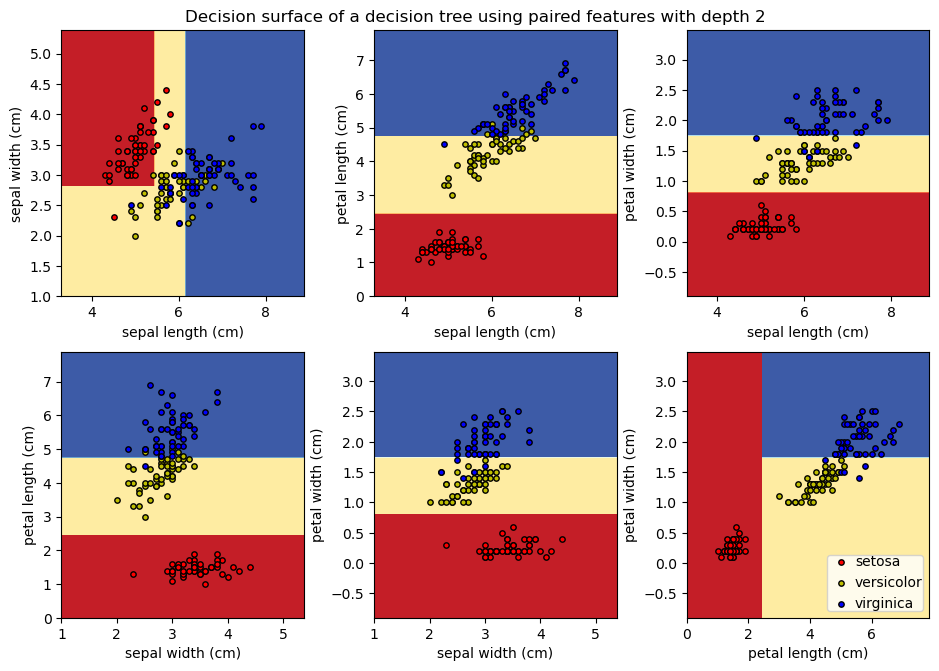

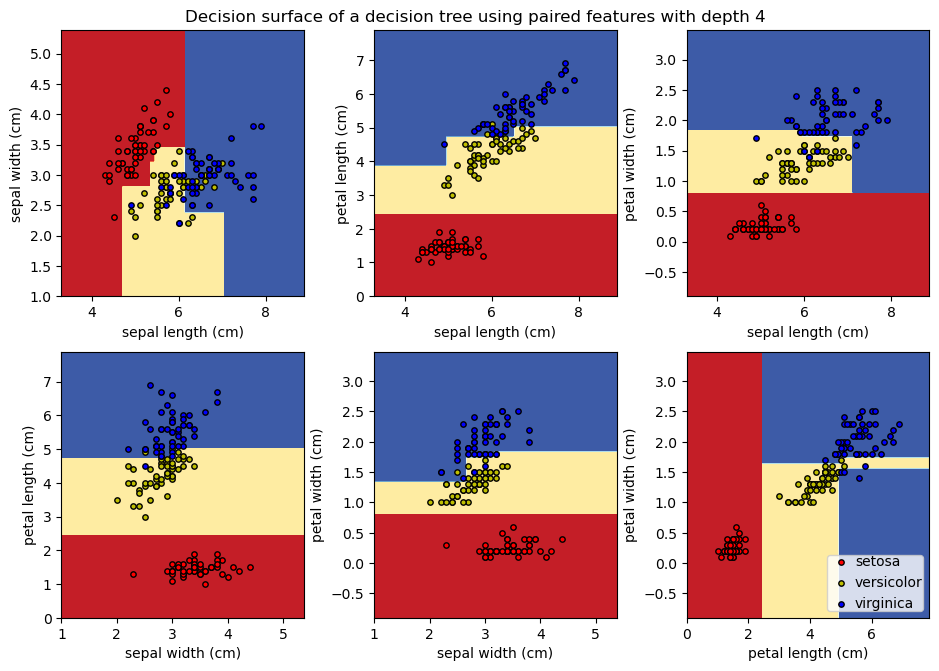

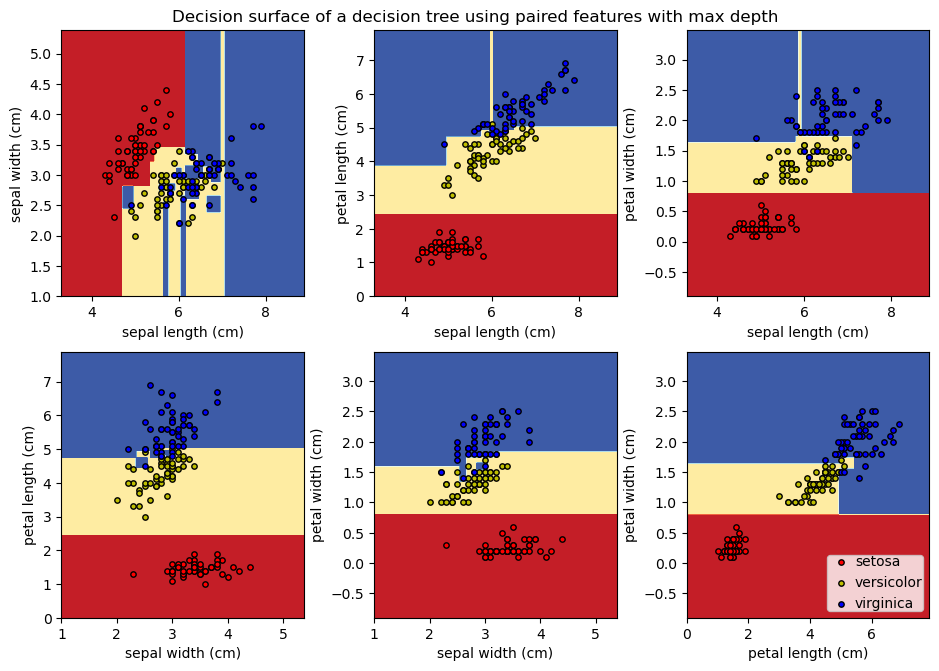

In [101]:
# From http://scikit-learn.org/stable/auto_examples/tree/plot_iris.html
# Max Depth 2
plotPairwiseDecisionTrees(2)
# Max Depth 4
plotPairwiseDecisionTrees(4)
# No Max Depth
plotPairwiseDecisionTrees()

**Questions for understanding:**
> 1. What do the colored points and regions represent?
> 2. What are some trends as the trees get deeper?
> 3. How do the decision boundaries change with depth?

As we can see, the deeper our tree goes, the higher the variance is within the tree, as the decision tree is tailored towards our training data, and could be completely different had we just added/removed a couple data points. However, it also has low bias, as it won't consistently classify certain data points incorrectly (it's too precise!)

Now, we'd love to have a decision tree that had both low bias and low variance, but it seems like it's a tradeoff for one or the other. So, it'd be ideal to get the best of both worlds, and get low bias and low variance. 

<a id='random_forest'></a>
# Random Forest

A single decision tree often results in poor predictions, as they are very simple and lack much complexity. Just cutting the feature space into separate regions does not perform very well, as these strict linear constraints prevent complex boundaries.

However, if we include many decision trees and create a **random forest**, we obtain drastically better results. 
The idea of a random forest is quite simple, take many decision trees and output their average guess.
<center>
<img src="RandomForest.png" width="60%">
Image from https://medium.com/@williamkoehrsen/random-forest-simple-explanation-377895a60d2d
</center>


In the case of classification, we take the most popular guess.   
In the case of regression, we take some form of the average guess.


Now, let's consider this exact setup. What would happen if we created many decision trees and took the most popular guess?

In practice, we could obtain the same decision tree over and over. This is because there is some optimal set of splitting values in the dataset to minimize entropy, even with different sets of data. Perhaps we have one feature that works very well in splitting the data, and it is always utilized as the first split in the tree. Then all decision trees end up looking quite similar, despite our efforts in bagging.

A solution to this problem is feature bagging. We may also select a subset of features for each tree to train on, thus each feature has a chance to be split on. 
<center>
<img src="RandomForestPipeline.jpg" width="40%">
Image from https://sites.google.com/site/rajhansgondane2506/publications
</center>


In summary, we begin with a dataset $\mathcal{D}$ of size $N$. 
1. We bootstrap the data so that we have $M$ new datasets $d_1,\ldots, d_M$ drawn with replacement of size $N$ from $\mathcal{D}$.
2. Select a subset of features $f_i$ for each new dataset $d_i$.
3. Fit a decision tree for each $d_i$ with features $f_i$.

Now to predict, we take the input data and feed it through each decision tree to get an output. Then we can take the most popular vote or the average output as the output of our model, based on the type of problem we are attempting to solve.

In [102]:
from sklearn.ensemble import RandomForestClassifier

In [103]:
model = RandomForestClassifier(n_estimators=200, max_depth=10)

In [104]:
model.fit(X_train_titanic, y_train_titanic)

RandomForestClassifier(max_depth=10, n_estimators=200)

In [105]:
accuracy(model.predict(X_valid_titanic), y_valid_titanic)

0.8268156424581006

<a id='KNN'></a>

# K Nearest Neighbors

K Nearest Neighbor(KNN) is a very simple, easy to understand, versatile and one of the topmost machine learning algorithms. KNN used in the variety of applications such as finance, healthcare, political science, handwriting detection, image recognition and video recognition. In Credit ratings, financial institutes will predict the credit rating of customers. In loan disbursement, banking institutes will predict whether the loan is safe or risky. In political science, classifying potential voters in two classes will vote or won’t vote. KNN algorithm used for both classification and regression problems. KNN algorithm based on feature similarity approach.

credit: https://www.datacamp.com/tutorial/k-nearest-neighbor-classification-scikit-learn

### What is K Nearest Neighbors

KNN is a non-parametric and lazy learning algorithm. Non-parametric means there is no assumption for underlying data distribution. In other words, the model structure determined from the dataset. This will be very helpful in practice where most of the real world datasets do not follow mathematical theoretical assumptions. 

Lazy algorithm means it does not need any training data points for model generation. All training data used in the testing phase. This makes training faster and testing phase slower and costlier. Costly testing phase means time and memory. In the worst case, KNN needs more time to scan all data points and scanning all data points will require more memory for storing training data.

### How it works

In KNN, K is the number of nearest neighbors. The number of neighbors is the core deciding factor. K is generally an odd number if the number of classes is 2. When K=1, then the algorithm is known as the nearest neighbor algorithm. This is the simplest case. Suppose P1 is the point, for which label needs to predict. First, you find the one closest point to P1 and then the label of the nearest point assigned to P1.

<img src="Knn_1.jpg" width="40%">

Suppose P1 is the point, for which label needs to predict. First, you find the k closest point to P1 and then classify points by majority vote of its k neighbors. Each object votes for their class and the class with the most votes is taken as the prediction. 

1. Calculate distance

2. Find closest neighbors

3. Vote for labels

<img src="KNN_2.jpg" width="70%">

## Curse of Dimensionality

KNN performs better with a lower number of features than a large number of features. You can say that when the number of features increases than it requires more data. Increase in dimension also leads to the problem of overfitting. To avoid overfitting, the needed data will need to grow exponentially as you increase the number of dimensions. This problem of higher dimension is known as the Curse of Dimensionality.

**Question**: How could we prevent the Curse of Dimensionality?

## How do you decide the number N?

Research has shown that no optimal number of neighbors suits all kind of data sets. Each dataset has it's own requirements. In the case of a small number of neighbors, the noise will have a higher influence on the result, and a large number of neighbors make it computationally expensive. Research has also shown that a small amount of neighbors are most flexible fit which will have low bias but high variance and a large number of neighbors will have a smoother decision boundary which means lower variance but higher bias.

Generally, Data scientists choose as an odd number if the number of classes is even. You can also check by generating the model on different values of k and check their performance.

## Coding Time!!

In [106]:
#Import scikit-learn dataset library
from sklearn import datasets

#Load dataset
wine = datasets.load_wine()

In [107]:
print(wine.feature_names)

['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']


In [108]:
print(wine.target_names)

['class_0' 'class_1' 'class_2']


First we will as usual split our training and test data!

In [109]:
# Import train_test_split function
from sklearn.model_selection import train_test_split

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.3) # 70% training and 30% test

Lets generate a model for K=5

In [110]:
#Import knearest neighbors Classifier model
from sklearn.neighbors import KNeighborsClassifier

#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5)

#Train the model using the training sets
knn.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = knn.predict(X_test)

Let's estimate, how accurately the classifier or model can predict the type of cultivars.

Accuracy can be computed by comparing actual test set values and predicted values.

In [111]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6296296296296297


Now let's try K=7

In [112]:
#Import knearest neighbors Classifier model
from sklearn.neighbors import KNeighborsClassifier

#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=7)

#Train the model using the training sets
knn.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = knn.predict(X_test)

In [113]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7222222222222222


In [116]:
acc = []
for i in range(1, 10):
    #Create KNN Classifier
    knn = KNeighborsClassifier(n_neighbors=i)

    #Train the model using the training sets
    knn.fit(X_train, y_train)

    #Predict the response for test dataset
    y_pred = knn.predict(X_train)
    acc.append(metrics.accuracy_score(y_train, y_pred))

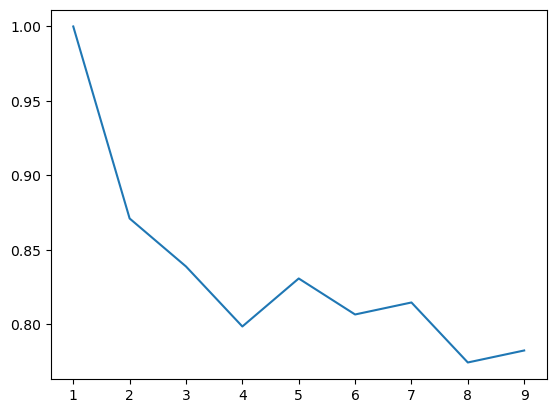

In [117]:
plt.plot(range(1,10), acc)

## Pros

The training phase of K-nearest neighbor classification is much faster compared to other classification algorithms. There is no need to train a model for generalization, That is why KNN is known as the simple and instance-based learning algorithm. KNN can be useful in case of nonlinear data. It can be used with the regression problem. Output value for the object is computed by the average of k closest neighbors value.

## Cons

The testing phase of K-nearest neighbor classification is slower and costlier in terms of time and memory. It requires large memory for storing the entire training dataset for prediction. KNN requires scaling of data because KNN uses the Euclidean distance between two data points to find nearest neighbors. Euclidean distance is sensitive to magnitudes. The features with high magnitudes will weight more than features with low magnitudes. KNN also not suitable for large dimensional data.

# Conclusion

From today's lecture you guys learned of the main methods in classification, such as decision trees, random forest, and K nearest neighbors. This is our last lecture this semester and hopefully through all these lectures you guys can take aspects of whatt you learned and apply it to your future.

# Thank You !!!